In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy
from scipy.stats import linregress
import matplotlib
import bluepysnap as bp

In [2]:
font = {'size'   : 6}

matplotlib.rc('font', **font)
%matplotlib ipympl

In [3]:
time = np.arange(1975,2200,.1)

In [4]:
def getHistAllTypes(path_to_sims,bins=None):

    numSims = 10
    numBins = 225

    allSpikes = {}

    s = bp.Simulation( path_to_sims + '/0/simulation_config.json' )
    c = s.circuit
    typeDF = list(c.nodes.get(group='hex_O1',properties=['mtype']))[0][1].loc['S1nonbarrel_neurons']

    typeList = np.unique(typeDF['mtype'].values)

    for i, t in enumerate(typeList):
        
        allSpikes[t] = np.zeros([numSims,numBins])

        typeIDs = list(typeDF[typeDF['mtype']==t].index)
   
        for sim in range(numSims):
        
            s = bp.Simulation( path_to_sims + '/'+str(sim)+'/simulation_config.json' )
        
            spikes = s.spikes['S1nonbarrel_neurons'].get(group=typeIDs,t_start=1975,t_stop=2200)
        
            if bins is None:
                
                spike_hist,bins = np.histogram(list(spikes.index),bins=numBins)
        
            else:
        
                spike_hist,_ = np.histogram(list(spikes.index),bins=bins)
        
        
            allSpikes[t][sim] = spike_hist 


    return allSpikes, bins

In [5]:
def getHistByLayer(path_to_sims, histByTypes):

    s = bp.Simulation( path_to_sims + '/0/simulation_config.json' )
    c = s.circuit
    

    histEXC = np.zeros((7,10,225))
    histINH = np.zeros((7,10,225))

    histList = [histEXC, histINH]

    for mtype in np.sort(np.unique(list(histByTypes.keys()))):

        synsDF = list(c.nodes.get(group=mtype,properties=['synapse_class']))[0][1].loc['S1nonbarrel_neurons'].iloc[0].values

        if synsDF=='EXC':
            synIdx = 0
        elif synsDF=='INH':
            synIdx = 1

        layer = int(mtype.split('_')[0].split('L')[1])

        if layer == 2 or layer == 3 or layer == 23:
            layer = 2

        histList[synIdx][layer] += histByTypes[mtype]


    return histList

In [6]:
def getEEGByLayer(path_to_sims, EEGsByTypes,duration=12000):

    s = bp.Simulation( path_to_sims + '/0/simulation_config.json' )
    c = s.circuit
    

    eegEXC = np.zeros((7,duration*10,2))
    eegINH = np.zeros((7,duration*10,2))

    eegList = [eegEXC, eegINH]

    for mtype in np.sort(np.unique(list(EEGsByTypes.keys()))):

        synsDF = list(c.nodes.get(group=mtype,properties=['synapse_class']))[0][1].loc['S1nonbarrel_neurons'].iloc[0].values

        if synsDF=='EXC':
            synIdx = 0
        elif synsDF=='INH':
            synIdx = 1

        layer = int(mtype.split('_')[0].split('L')[1])

        if layer == 2 or layer == 3 or layer == 23:
            layer = 2

        eegList[synIdx][layer] += EEGsByTypes[mtype]


    return eegList

In [7]:
s = 'original/1a8bf077-4f6c-4bcb-b257-ca1f3d2388cd/'
s1 = 'disconnected/d851ea52-d571-420f-bd23-d77489af0fac/'
s2 = 'rewired/f090d92c-29b1-4033-96d2-e1a67b33dab6/'

In [8]:
spikes_original_type, bins = getHistAllTypes(s)
spikes_disconnected_type, _ = getHistAllTypes(s1,bins)
spikes_rewired_type, _ = getHistAllTypes(s2,bins)

bins_hist = bins

bins = (bins[:-1]+bins[1:])/2



In [9]:
histList = getHistByLayer(s, spikes_original_type)
histListDisconnected = getHistByLayer(s1, spikes_disconnected_type)
histListRewired = getHistByLayer(s2, spikes_rewired_type)

In [10]:
EEGsByType = np.load(s+'EEGs.npy',allow_pickle=True).item()
EEGsByType_Disconnected = np.load(s1+'EEGs.npy',allow_pickle=True).item()
EEGsByType_Rewired = np.load(s2+'EEGs.npy',allow_pickle=True).item()

In [14]:
EEGsByType['L5_UPC']

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.01714084e-11, -3.41731903e-18],
       [-7.53863379e-11, -1.79437313e-17],
       ...,
       [-8.13724560e-09,  8.07504923e-15],
       [-8.25986720e-09,  9.82703880e-15],
       [-8.42789901e-09,  1.12152321e-14]])

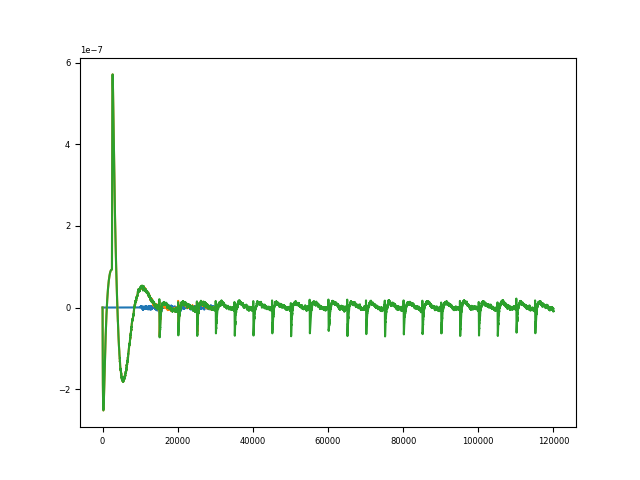

In [18]:
plt.figure()
plt.plot(EEGsByType['L5_UPC'][:30000,0]-EEGsByType_Disconnected['L5_UPC'][:,0])
plt.plot(EEGsByType_Disconnected['L5_UPC'][:,0])
plt.plot(EEGsByType['L5_UPC'][:,0])
plt.show()

In [22]:
eegList = np.array(getEEGByLayer(s,EEGsByType))
eegListDisconnected = np.array(getEEGByLayer(s1,EEGsByType_Disconnected,3000))
eegListRewired = np.array(getEEGByLayer(s2,EEGsByType_Rewired,3000))

In [23]:
eegList.shape

(2, 7, 120000, 2)

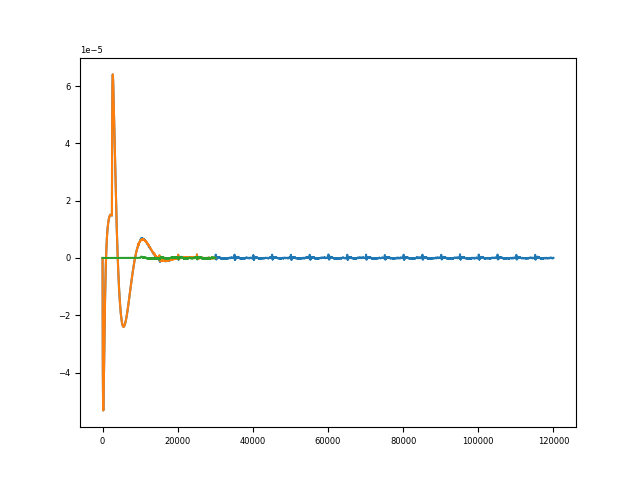

In [28]:
plt.figure()
plt.plot(eegList[0,5,:,0])
plt.plot(eegListDisconnected[0,5,:,0])
plt.plot(eegList[0,5,:30000,0]-eegListDisconnected[0,5,:,0])

In [63]:
def getTimeIndices(bins,startTime=0,endTime=12000):

    time = np.arange(startTime,endTime,.1)

    timeIndices = []
    for t in bins:
        index = np.argmin(np.abs(t-time))
        timeIndices.append(index)

    return timeIndices

def getCorrelations(EEGs, spikes,bins,duration=12000):

    timeIndices = getTimeIndices(bins,duration)

    correlationMatrix = np.zeros([len(spikes),len(EEGs)])

    keyList = np.sort(list(EEGs.keys()))
    
    for i in range(len(spikes)):
        
        spikeKey = keyList[i]
    
        for j in range(len(EEGs)):
        
            eegKey = keyList[j]
            
            correlationMatrix[i,j] = scipy.stats.pearsonr(np.mean(spikes_original_type[spikeKey],axis=0),EEGsByType[eegKey][timeIndices][:,0]).statistic

    return correlationMatrix

def getCorrelationsAbs(EEGs, spikes,bins,duration=12000):

    timeIndices = getTimeIndices(bins,duration)

    correlationMatrix = np.zeros([len(spikes),len(EEGs)])

    keyList = np.sort(list(EEGs.keys()))
    
    for i in range(len(spikes)):
        
        spikeKey = keyList[i]
    
        for j in range(len(EEGs)):
        
            eegKey = keyList[j]
            
            correlationMatrix[i,j] = scipy.stats.pearsonr(np.mean(spikes_original_type[spikeKey],axis=0),np.abs(EEGsByType[eegKey][timeIndices][:,0])).statistic

    return correlationMatrix

In [67]:
def getCorrelationsByLayer(EEGs, spikes,bins,startTime=0,endTime=12000):

    timeIndices = getTimeIndices(bins,startTime,endTime)

    correlationMatrix = np.zeros([5,5])
    
    for i in range(5):
    
        for j in range(5):
        
            correlationMatrix[i,j] = scipy.stats.pearsonr(np.mean(spikes[i],axis=0),EEGs[j][timeIndices][:,0]).statistic

    return correlationMatrix

In [17]:
correlationMatrix = getCorrelations(EEGsByType,spikes_original_type,bins)

In [18]:
correlationMatrixAbs = getCorrelationsAbs(EEGsByType,spikes_original_type,bins)

In [19]:
correlationsExcExc = getCorrelationsByLayer(eegList[0][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins)
correlationsExcInh = getCorrelationsByLayer(eegList[1][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins)
correlationsInhExc = getCorrelationsByLayer(eegList[0][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins)
correlationsInhInh = getCorrelationsByLayer(eegList[1][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins)

/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [17]:
correlationsExcExcAbs = getCorrelationsByLayer(np.abs(eegList[0][[1,2,4,5,6]]),histList[0][[1,2,4,5,6]],bins)
correlationsExcInhAbs = getCorrelationsByLayer(np.abs(eegList[1][[1,2,4,5,6]]),histList[0][[1,2,4,5,6]],bins)
correlationsInhExcAbs = getCorrelationsByLayer(np.abs(eegList[0][[1,2,4,5,6]]),histList[1][[1,2,4,5,6]],bins)
correlationsInhInhAbs = getCorrelationsByLayer(np.abs(eegList[1][[1,2,4,5,6]]),histList[1][[1,2,4,5,6]],bins)

In [18]:
correlationsExcExcD = getCorrelationsByLayer(eegListDisconnected[0][[1,2,4,5,6]],histListDisconnected[0][[1,2,4,5,6]],bins,3000)
correlationsExcInhD = getCorrelationsByLayer(eegListDisconnected[1][[1,2,4,5,6]],histListDisconnected[0][[1,2,4,5,6]],bins,3000)
correlationsInhExcD = getCorrelationsByLayer(eegListDisconnected[0][[1,2,4,5,6]],histListDisconnected[1][[1,2,4,5,6]],bins,3000)
correlationsInhInhD = getCorrelationsByLayer(eegListDisconnected[1][[1,2,4,5,6]],histListDisconnected[1][[1,2,4,5,6]],bins,3000)

In [19]:
correlationsExcExcAbsD = getCorrelationsByLayer(np.abs(eegListDisconnected[0][[1,2,4,5,6]]),histListDisconnected[0][[1,2,4,5,6]],bins)
correlationsExcInhAbsD = getCorrelationsByLayer(np.abs(eegListDisconnected[1][[1,2,4,5,6]]),histListDisconnected[0][[1,2,4,5,6]],bins)
correlationsInhExcAbsD = getCorrelationsByLayer(np.abs(eegListDisconnected[0][[1,2,4,5,6]]),histListDisconnected[1][[1,2,4,5,6]],bins)
correlationsInhInhAbsD = getCorrelationsByLayer(np.abs(eegListDisconnected[1][[1,2,4,5,6]]),histListDisconnected[1][[1,2,4,5,6]],bins)

In [20]:
correlationsExcExcR = getCorrelationsByLayer(eegListRewired[0][[1,2,4,5,6]],histListRewired[0][[1,2,4,5,6]],bins,3000)
correlationsExcInhR = getCorrelationsByLayer(eegListRewired[1][[1,2,4,5,6]],histListRewired[0][[1,2,4,5,6]],bins,3000)
correlationsInhExcR = getCorrelationsByLayer(eegListRewired[0][[1,2,4,5,6]],histListRewired[1][[1,2,4,5,6]],bins,3000)
correlationsInhInhR = getCorrelationsByLayer(eegListRewired[1][[1,2,4,5,6]],histListRewired[1][[1,2,4,5,6]],bins,3000)

In [25]:
correlationsExcExcAbsR = getCorrelationsByLayer(np.abs(eegListRewired[0][[1,2,4,5,6]]),histListRewired[0][[1,2,4,5,6]],bins,3000)
correlationsExcInhAbsR = getCorrelationsByLayer(np.abs(eegListRewired[1][[1,2,4,5,6]]),histListRewired[0][[1,2,4,5,6]],bins,3000)
correlationsInhExcAbsR = getCorrelationsByLayer(np.abs(eegListRewired[0][[1,2,4,5,6]]),histListRewired[1][[1,2,4,5,6]],bins,3000)
correlationsInhInhAbsR = getCorrelationsByLayer(np.abs(eegListRewired[1][[1,2,4,5,6]]),histListRewired[1][[1,2,4,5,6]],bins,3000)

In [59]:
22000-19750

2250

In [58]:
eegDifference = np.array(eegList)[:,:,19750:22000,:] - np.array(eegListDisconnected)[:,:,19750:22000,:]

In [70]:
eegDifferenceP = np.array(eegList)[:,:,20000:20500,:] - np.array(eegListDisconnected)[:,:,20000:20500,:]

In [82]:
eegDifferenceN = np.array(eegList)[:,:,20500:22000,:] - np.array(eegListDisconnected)[:,:,20500:22000,:]

In [68]:
correlationsExcExcDiff = getCorrelationsByLayer(eegDifference[0][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins,1975,2200)
correlationsExcInhDiff = getCorrelationsByLayer(eegDifference[1][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins,1975,2200)
correlationsInhExcDiff = getCorrelationsByLayer(eegDifference[0][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins,1975,2200)
correlationsInhInhDiff = getCorrelationsByLayer(eegDifference[1][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins,1975,2200)

/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [72]:
correlationsExcExcDiffP = getCorrelationsByLayer(eegDifferenceP[0][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins,2000,2050)
correlationsExcInhDiffP = getCorrelationsByLayer(eegDifferenceP[1][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins,2000,2050)
correlationsInhExcDiffP = getCorrelationsByLayer(eegDifferenceP[0][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins,2000,2050)
correlationsInhInhDiffP = getCorrelationsByLayer(eegDifferenceP[1][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins,2000,2050)

/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [83]:
correlationsExcExcDiffN = getCorrelationsByLayer(eegDifferenceN[0][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins,2050,2200)
correlationsExcInhDiffN = getCorrelationsByLayer(eegDifferenceN[1][[1,2,4,5,6]],histList[0][[1,2,4,5,6]],bins,2050,2200)
correlationsInhExcDiffN = getCorrelationsByLayer(eegDifferenceN[0][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins,2050,2200)
correlationsInhInhDiffN = getCorrelationsByLayer(eegDifferenceN[1][[1,2,4,5,6]],histList[1][[1,2,4,5,6]],bins,2050,2200)

/gpfs/bbp.cscs.ch/home/tharayil/conntilitEnv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


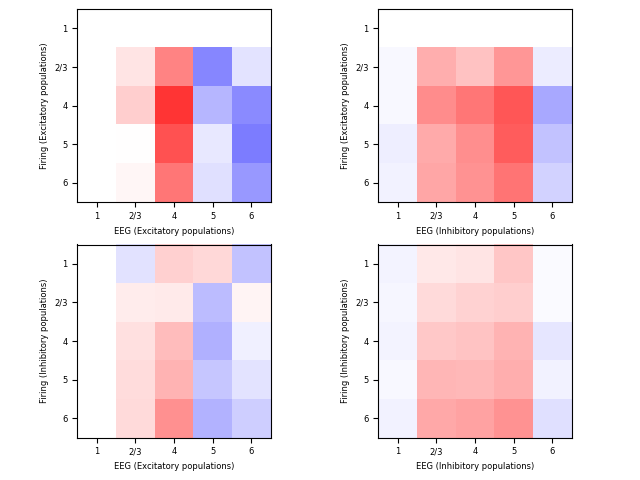

In [69]:
plt.figure()

plt.subplot(2,2,1)
plt.imshow(correlationsExcExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(2,2,2)
plt.imshow(correlationsExcInhDiff,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(2,2,3)
plt.imshow(correlationsInhExcDiff,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(2,2,4)
plt.imshow(correlationsInhInhDiff,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.tight_layout()

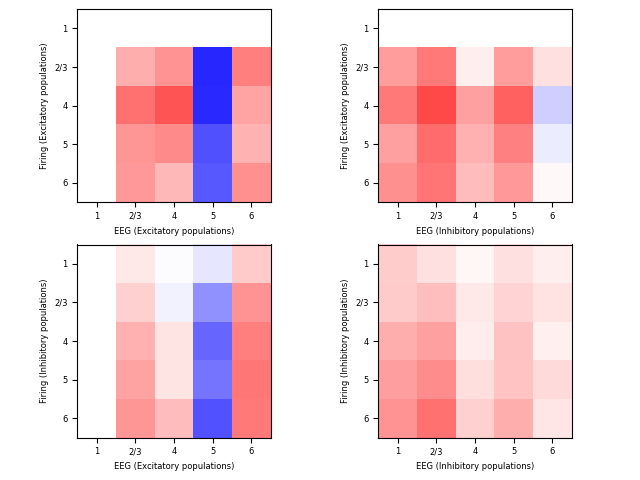

In [73]:
plt.figure()

plt.subplot(2,2,1)
plt.imshow(correlationsExcExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(2,2,2)
plt.imshow(correlationsExcInhDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(2,2,3)
plt.imshow(correlationsInhExcDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(2,2,4)
plt.imshow(correlationsInhInhDiffP,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.tight_layout()

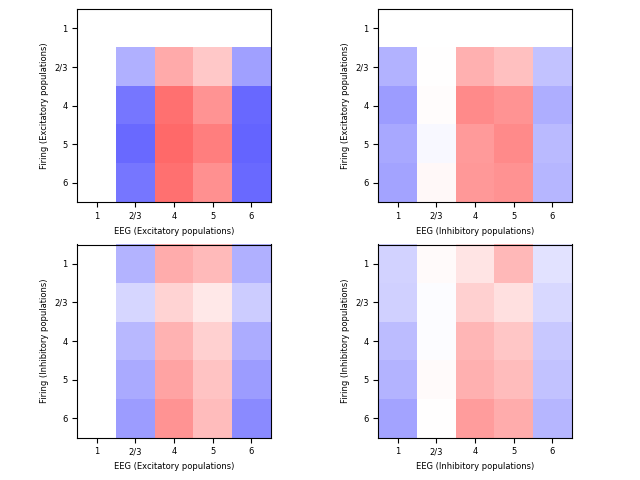

In [84]:
plt.figure()

plt.subplot(2,2,1)
plt.imshow(correlationsExcExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(2,2,2)
plt.imshow(correlationsExcInhDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(2,2,3)
plt.imshow(correlationsInhExcDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(2,2,4)
plt.imshow(correlationsInhInhDiffN,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.tight_layout()

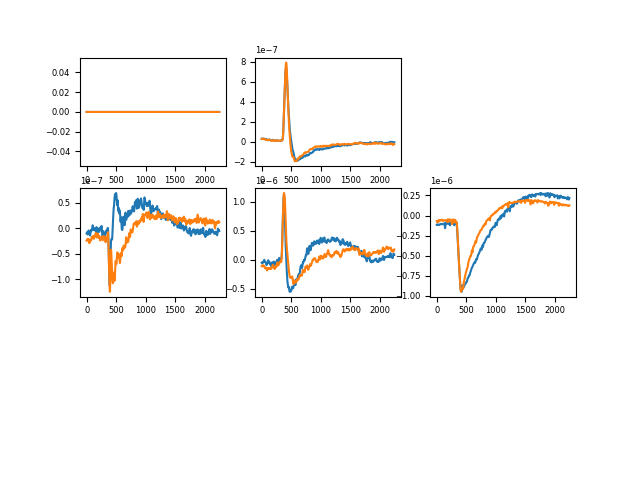

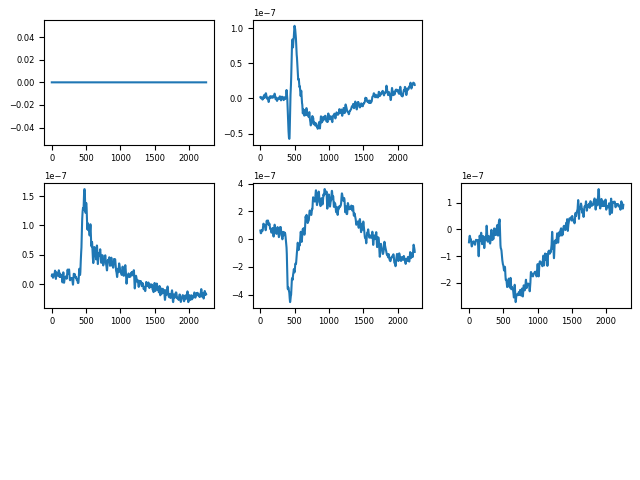

In [80]:
plt.figure()
for i in [1,2,4,5,6]:
    plt.subplot(3,3,i)
    plt.plot(eegList[0,i,19750:22000,0])
    plt.plot(eegListDisconnected[0,i,19750:22000,0])

plt.figure()
for i in [1,2,4,5,6]:
    plt.subplot(3,3,i)
    plt.plot(eegDifference[0,i,:,0])

plt.tight_layout()


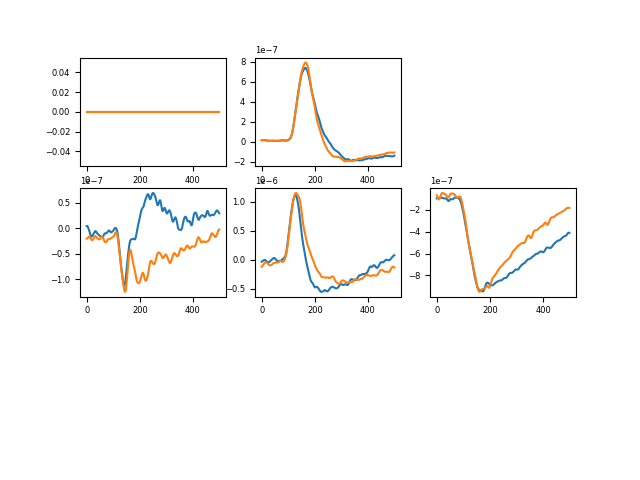

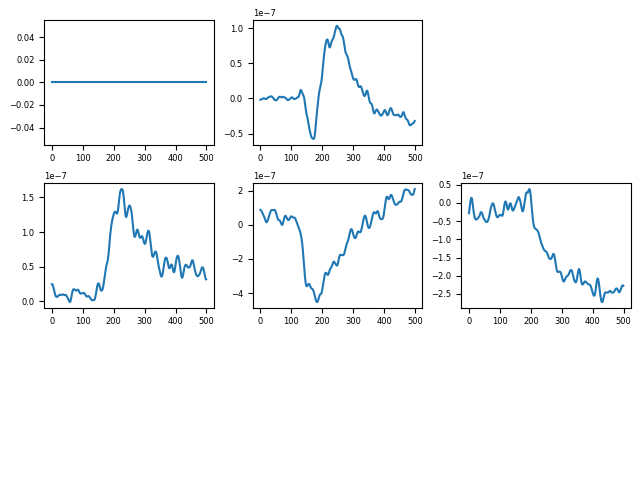

In [81]:
plt.figure()
for i in [1,2,4,5,6]:
    plt.subplot(3,3,i)
    plt.plot(eegList[0,i,20000:20500,0])
    plt.plot(eegListDisconnected[0,i,20000:20500,0])

plt.figure()
for i in [1,2,4,5,6]:
    plt.subplot(3,3,i)
    plt.plot(eegDifferenceP[0,i,:,0])

plt.tight_layout()


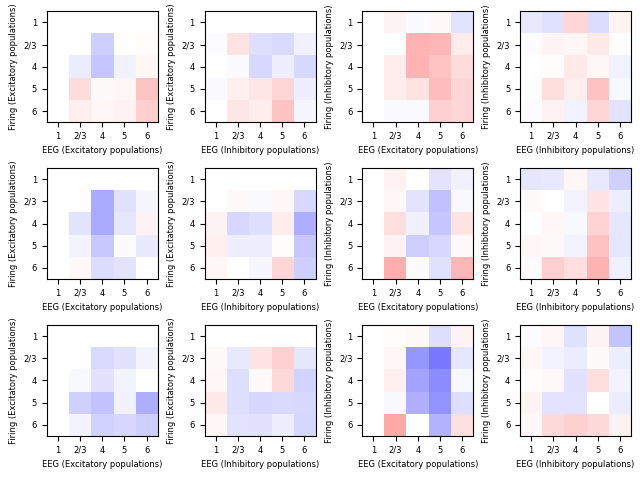

In [27]:
plt.figure()
plt.subplot(3,4,1)

plt.imshow(correlationsExcExcAbs-correlationsExcExcAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,2)
plt.imshow(correlationsExcInhAbs-correlationsExcInhAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,3)
plt.imshow(correlationsInhExcAbs-correlationsInhExcAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(3,4,4)
plt.imshow(correlationsInhInhAbs-correlationsInhInhAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')




plt.subplot(3,4,5)

plt.imshow(correlationsExcExcAbs-correlationsExcExcAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,6)
plt.imshow(correlationsExcInhAbs-correlationsExcInhAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,7)
plt.imshow(correlationsInhExcAbs-correlationsInhExcAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(3,4,8)
plt.imshow(correlationsInhInhAbs-correlationsInhInhAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')




plt.subplot(3,4,9)

plt.imshow(correlationsExcExcAbsR-correlationsExcExcAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,10)
plt.imshow(correlationsExcInhAbsR-correlationsExcInhAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,11)
plt.imshow(correlationsInhExcAbsR-correlationsInhExcAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(3,4,12)
plt.imshow(correlationsInhInhAbsR-correlationsInhInhAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.tight_layout()
plt.show()


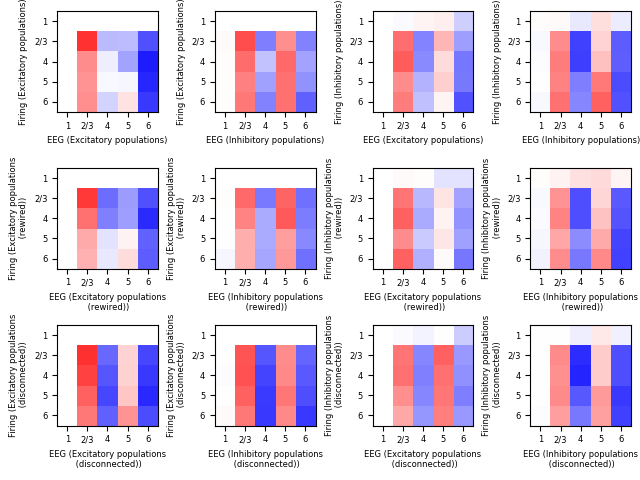

In [23]:
plt.figure()
plt.subplot(3,4,1)

plt.imshow(correlationsExcExc,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,2)
plt.imshow(correlationsExcInh,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,3)
plt.imshow(correlationsInhExc,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(3,4,4)
plt.imshow(correlationsInhInh,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')




plt.subplot(3,4,5)

plt.imshow(correlationsExcExcR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (rewired))')
plt.ylabel('Firing (Excitatory populations\n (rewired))')

plt.subplot(3,4,6)
plt.imshow(correlationsExcInhR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (rewired))')
plt.ylabel('Firing (Excitatory populations\n (rewired))')

plt.subplot(3,4,7)
plt.imshow(correlationsInhExcR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (rewired))')
plt.ylabel('Firing (Inhibitory populations\n (rewired))')

plt.subplot(3,4,8)
plt.imshow(correlationsInhInhR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (rewired))')
plt.ylabel('Firing (Inhibitory populations\n (rewired))')




plt.subplot(3,4,9)

plt.imshow(correlationsExcExcD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (disconnected))')
plt.ylabel('Firing (Excitatory populations\n (disconnected))')

plt.subplot(3,4,10)
plt.imshow(correlationsExcInhD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (disconnected))')
plt.ylabel('Firing (Excitatory populations\n (disconnected))')

plt.subplot(3,4,11)
plt.imshow(correlationsInhExcD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (disconnected))')
plt.ylabel('Firing (Inhibitory populations\n (disconnected))')

plt.subplot(3,4,12)
plt.imshow(correlationsInhInhD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (disconnected))')
plt.ylabel('Firing (Inhibitory populations\n (disconnected))')

plt.tight_layout()
plt.show()

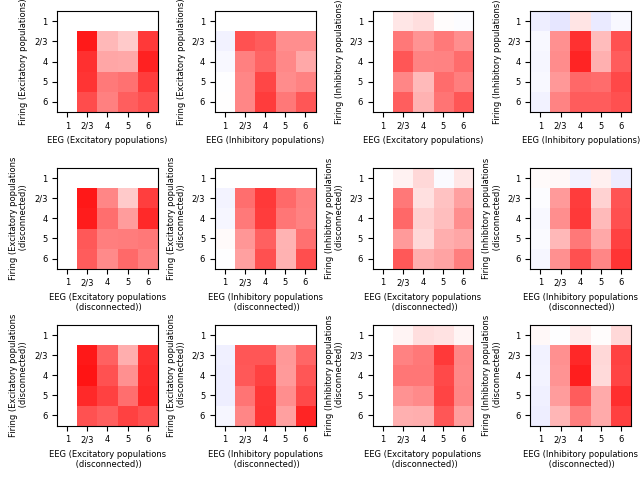

In [28]:
plt.figure()
plt.subplot(3,4,1)

plt.imshow(correlationsExcExcAbs,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,2)
plt.imshow(correlationsExcInhAbs,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Excitatory populations)')

plt.subplot(3,4,3)
plt.imshow(correlationsInhExcAbs,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(3,4,4)
plt.imshow(correlationsInhInhAbs,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations)')
plt.ylabel('Firing (Inhibitory populations)')

plt.subplot(3,4,5)

plt.imshow(correlationsExcExcAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (disconnected))')
plt.ylabel('Firing (Excitatory populations\n (disconnected))')

plt.subplot(3,4,6)
plt.imshow(correlationsExcInhAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (disconnected))')
plt.ylabel('Firing (Excitatory populations\n (disconnected))')

plt.subplot(3,4,7)
plt.imshow(correlationsInhExcAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (disconnected))')
plt.ylabel('Firing (Inhibitory populations\n (disconnected))')

plt.subplot(3,4,8)
plt.imshow(correlationsInhInhAbsR,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (disconnected))')
plt.ylabel('Firing (Inhibitory populations\n (disconnected))')


plt.subplot(3,4,9)

plt.imshow(correlationsExcExcAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (disconnected))')
plt.ylabel('Firing (Excitatory populations\n (disconnected))')

plt.subplot(3,4,10)
plt.imshow(correlationsExcInhAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (disconnected))')
plt.ylabel('Firing (Excitatory populations\n (disconnected))')

plt.subplot(3,4,11)
plt.imshow(correlationsInhExcAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Excitatory populations\n (disconnected))')
plt.ylabel('Firing (Inhibitory populations\n (disconnected))')

plt.subplot(3,4,12)
plt.imshow(correlationsInhInhAbsD,cmap='bwr',vmin=-1,vmax=1)
plt.xticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.yticks(np.arange(5),labels=['1','2/3','4','5','6'])
plt.xlabel('EEG (Inhibitory populations\n (disconnected))')
plt.ylabel('Firing (Inhibitory populations\n (disconnected))')

plt.tight_layout()
plt.show()

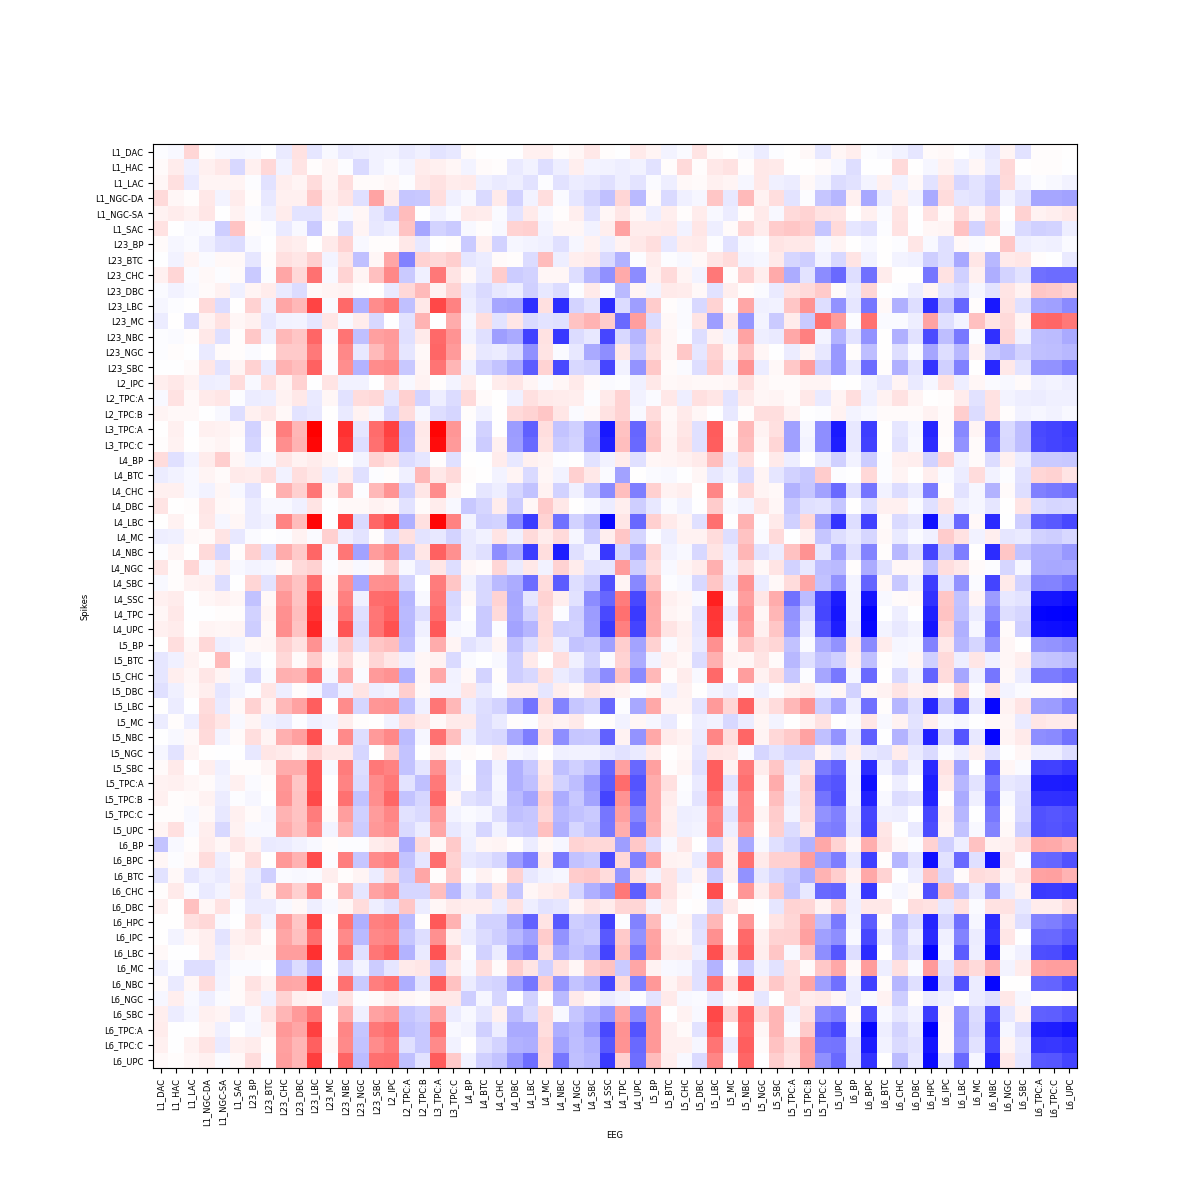

In [45]:
keyList = np.sort(list(EEGsByType.keys()))
plt.figure(figsize=(12,12))
plt.imshow(correlationMatrix,cmap='bwr')
plt.yticks(np.arange(60),labels=keyList)
plt.xticks(np.arange(60),labels=keyList,rotation=90)
plt.ylabel('Spikes')
plt.xlabel('EEG')
plt.show()

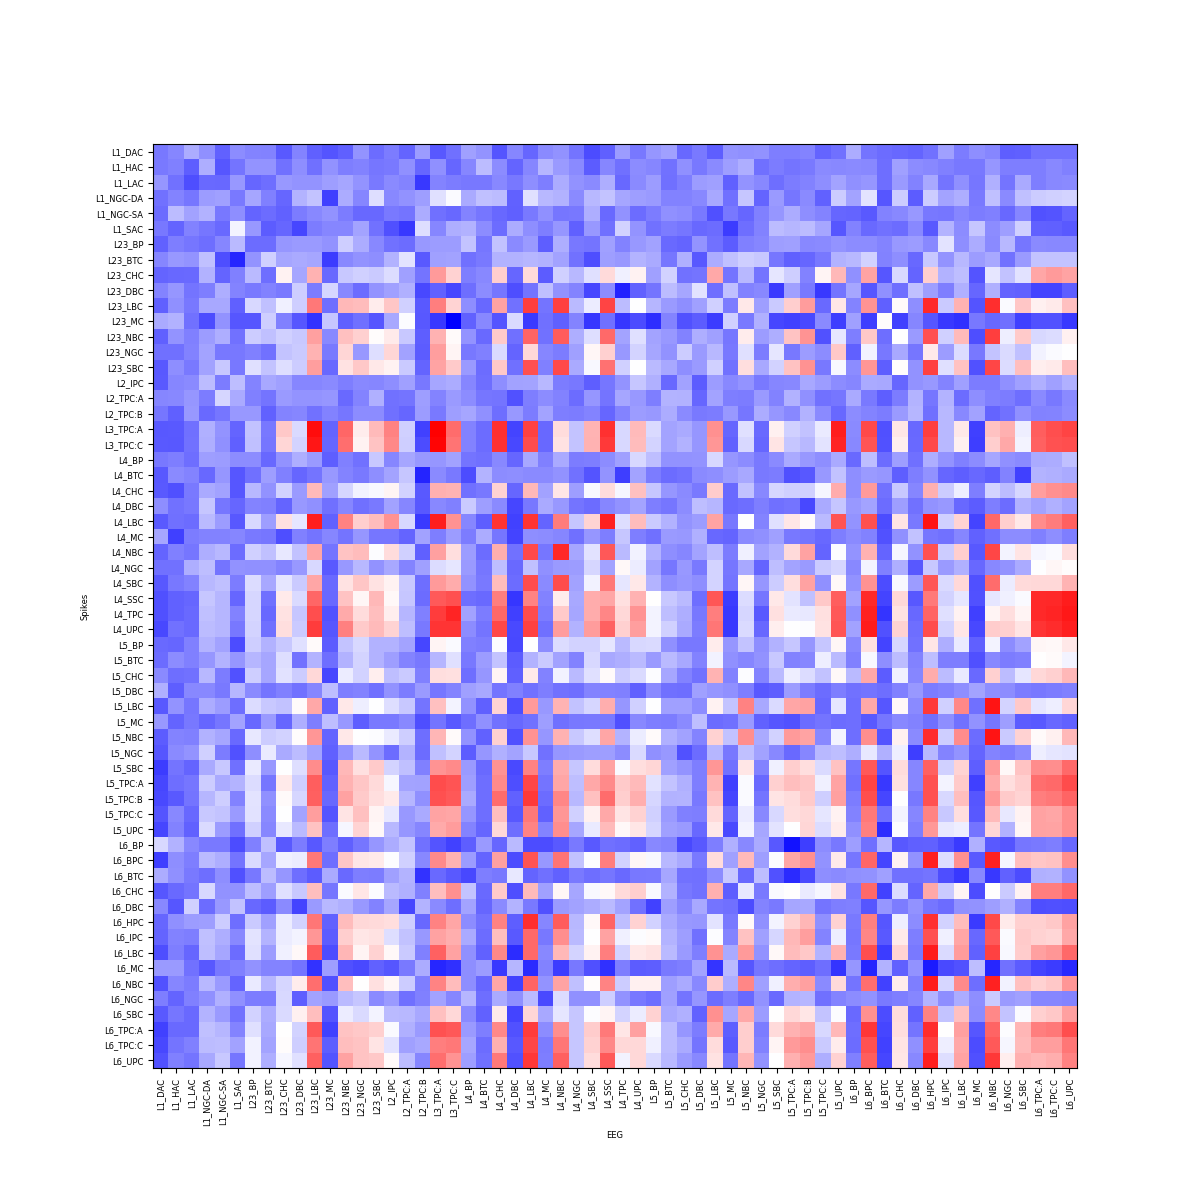

In [51]:
keyList = np.sort(list(EEGsByType.keys()))
plt.figure(figsize=(12,12))
plt.imshow(correlationMatrixAbs,cmap='bwr')
plt.yticks(np.arange(60),labels=keyList)
plt.xticks(np.arange(60),labels=keyList,rotation=90)
plt.ylabel('Spikes')
plt.xlabel('EEG')
plt.show()

In [55]:
'L1_DAC'.split('_')[0].split('L')[1]

'1'

In [35]:
typeDF = list(c.nodes.get(group='L1_DAC',properties=['synapse_class']))[0][1].loc['S1nonbarrel_neurons']

In [36]:
typeDF

,synapse_class
node_ids,
0,INH
1,INH
2,INH
3,INH
4,INH
...,...
8466,INH
8467,INH
8468,INH
